Check to see if Feedback Alignment gives the desired encoders and accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab

import nengo_encoder_learning as nel

In [2]:
from collections import namedtuple

In [3]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [4]:
dimensions = 64
n_neurons = 500
seed = 8

In [5]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(16, 16, dimensions, seed, norm=True)

# Try it with clean inputs

In [45]:
all_pairs = np.concatenate((fan1_pair_vecs, fan2_pair_vecs))
all_pairs.shape

(32, 64)

In [46]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                         intercepts=nengo.dists.CosineSimilarity(dimensions+2))
    
    output = nengo.Node(size_in=dimensions)
    
    c = nengo.Connection(ens, output, eval_points=all_pairs)

In [47]:
mod_ens, error = nel.improve(c, learning_rate=1e-3, steps=1000, seed=0)

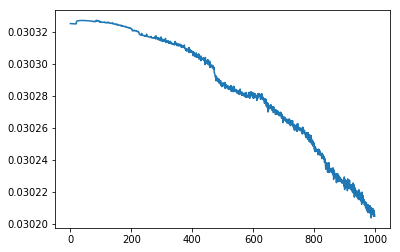

In [48]:
plt.plot(error)

## Check MEG response

In [49]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [50]:
with nengo.Network() as model:
    model.ensembles.append(mod_ens)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [51]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(mod_ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

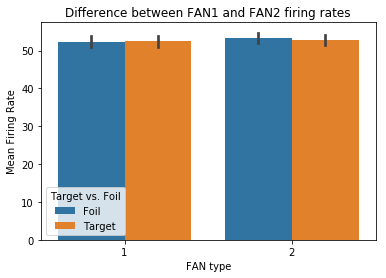

In [52]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Foil", "Target")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

# With noisier inputs

In [53]:
eval_points = []
function = []
mag = 0.01

for n in range(10):
    eval_points.append(all_pairs + np.random.normal(size=all_pairs.shape) * mag)
    function.append(all_pairs)

eval_points = np.concatenate(eval_points)
eval_points /= np.linalg.norm(eval_points, axis=1, keepdims=True)
print(eval_points.shape)
function = np.concatenate(function)
print(function.shape)

(320, 64)
(320, 64)


In [54]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                         intercepts=nengo.dists.CosineSimilarity(dimensions+2))
    
    output = nengo.Node(size_in=dimensions)
    
    c = nengo.Connection(ens, output, eval_points=eval_points, function=function)

In [55]:
mod_ens, error = nel.improve(c, learning_rate=1e-2, steps=1000, seed=0)

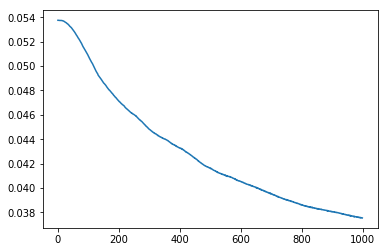

In [56]:
plt.plot(error)

## Check MEG response

In [57]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [58]:
with nengo.Network() as model:
    model.ensembles.append(mod_ens)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [59]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(mod_ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

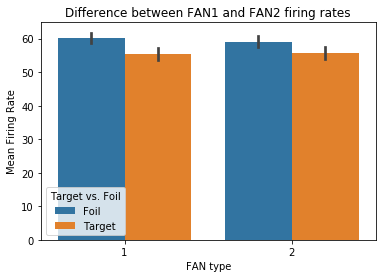

In [60]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Foil", "Target")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)